# Week 1 Lecture 2 - The garden of forking data


Throughout the course we will be using these [Jupyter notebooks](https://jupyter.org/) to develop, run, and share Python code. They work with R also.

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [1]:
# Import python packages
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import random as rd
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Grid approximation

The best way to understand how Bayes theorem works is to work through it by hand - the grid approximation is a good way to do this because you can see visually how parameters and data interact through the likelhood. It also gives a sense of how priors become posteiors.

We'll use the globe tossing example because it conveys so well how probability can be built up and used from scratch.

In [2]:
# Define grid
p_grid = np.linspace(0,1,20)
p_grid

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [3]:
# Define prior
prior = np.ones(20)
prior

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [4]:
# Normalize
prior = prior/sum(prior)
prior1 = prior
prior

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

Next we need to define the likelihood which, because it is descrete, is given by the probability mass function (PMF)

$$
\binom{n}{k}p^{x}(1-p)^{n-x}
$$

where

$$
\binom{n}{k} = \frac{n!}{k!(n - k)!}
$$

which in code is

In [5]:
from math import factorial as f

# Binomial distribution
def dbinom(x,n,p):
    return f(n)/(f(x)*f(n-x))*p**(x)*(1-p)**(n-x)

# Data loop

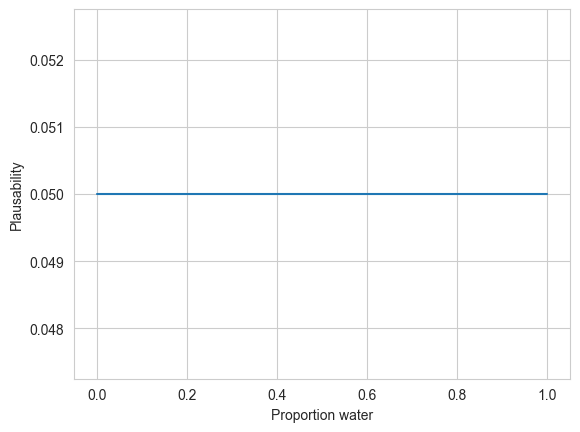

In [6]:
# Plot prior over range of p_grid
plt.plot(p_grid, prior)
plt.xlabel('Proportion water'),plt.ylabel('Plausability');

In [7]:
# New observations
W = 0
L = 1
# Number of trials
N = W+L

# Calculate likelihood
likelihood = dbinom(W,N,p_grid)
likelihood

array([1.        , 0.94736842, 0.89473684, 0.84210526, 0.78947368,
       0.73684211, 0.68421053, 0.63157895, 0.57894737, 0.52631579,
       0.47368421, 0.42105263, 0.36842105, 0.31578947, 0.26315789,
       0.21052632, 0.15789474, 0.10526316, 0.05263158, 0.        ])

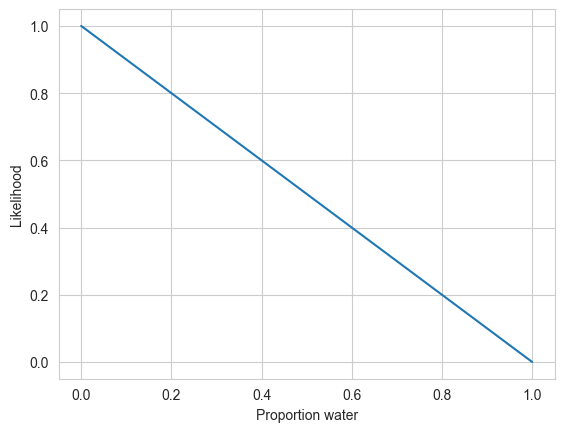

In [8]:
# Plot likelihood over range of p_grid
plt.plot(p_grid, likelihood)
plt.xlabel('Proportion water'),plt.ylabel('Likelihood');

In [9]:
sum(likelihood)

10.000000000000002

In [10]:
likelihood*prior

array([0.05      , 0.04736842, 0.04473684, 0.04210526, 0.03947368,
       0.03684211, 0.03421053, 0.03157895, 0.02894737, 0.02631579,
       0.02368421, 0.02105263, 0.01842105, 0.01578947, 0.01315789,
       0.01052632, 0.00789474, 0.00526316, 0.00263158, 0.        ])

In [11]:
# Normalizing constant
sum(likelihood*prior)

0.5

In [12]:
# Bayes theorem
posterior = (likelihood*prior)/sum(likelihood*prior)
posterior

array([0.1       , 0.09473684, 0.08947368, 0.08421053, 0.07894737,
       0.07368421, 0.06842105, 0.06315789, 0.05789474, 0.05263158,
       0.04736842, 0.04210526, 0.03684211, 0.03157895, 0.02631579,
       0.02105263, 0.01578947, 0.01052632, 0.00526316, 0.        ])

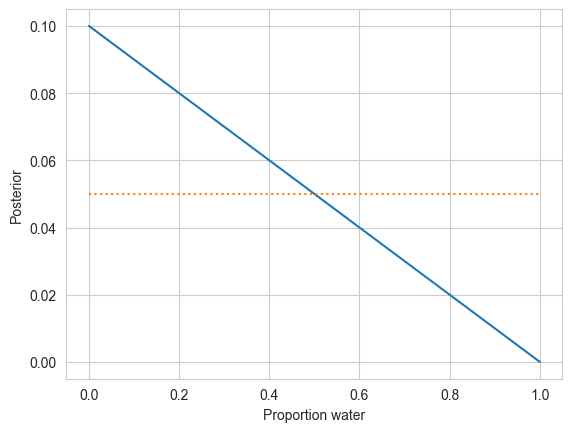

In [13]:
# Plot posterior over range of p_grid
plt.plot(p_grid, posterior)
plt.plot(p_grid, prior,linestyle=":")
plt.xlabel('Proportion water'),plt.ylabel('Posterior');

In [14]:
# Update new prior
prior = posterior

Or, we can do it all at once, with all the data

In [15]:
# New observations
W = 
L = 
# Number of trials
N = W+L

# Calculate likelihood
likelihood = dbinom(W,N,p_grid)
likelihood
# Bayes theorem
posterior = (likelihood*prior1)/sum(likelihood*prior1)
posterior

SyntaxError: invalid syntax (3222553597.py, line 2)

In [ ]:
# Plot posterior over range of p_grid
plt.plot(p_grid, posterior)
plt.plot(p_grid, prior1,linestyle=":")
plt.xlabel('Proportion water'),plt.ylabel('Posterior');

With this code we have built a Bayesian model to estimate the proportion of water on the earth's surface by recording the number of times our right hand lands on water versus land, given a default 'ignorant' prior. However our heterogenious educations give us some sense better than ignorance about what proportion of the earth is water. We can encode this information in a new prior and see what the data show. There are many ways to do this, but one way is to weight each value of p_grid by our sense of how likely they are.

In [ ]:
p_grid

In [ ]:
# Subjective prior
my_prior = np.array([0,0,0,0,0,0,0,0,0.0,0.,0.,0.,0.,0.,0.,0.0,0.0,0.0,0,0])

In [ ]:
sum(my_prior)

In [ ]:
# Standardize
my_prior = my_prior/sum(my_prior)

In [ ]:
sum(my_prior)

In [ ]:
# Plot my prior over range of p_grid
plt.plot(p_grid,my_prior)
plt.xlabel('Proportion water'),plt.ylabel('Prior');

In [ ]:
# Bayes theorem
posterior2 = (likelihood*my_prior)/sum(likelihood*my_prior)
posterior2

In [ ]:
# Plot posterior2 over range of p_grid
plt.plot(p_grid, np.ones(20)*0.05, label='Flat prior', c='dodgerblue', linestyle=":")
plt.plot(p_grid, my_prior, label='My prior', c='red', linestyle=":")
plt.plot(p_grid, posterior, label='Flat posterior', c='dodgerblue')
plt.plot(p_grid, posterior2, label='My posterior', c='red')
plt.legend()
plt.xlabel('Proportion water'),plt.ylabel('Posterior');

# Quadratic approximation

Grid approximations are helpful for learning how Bayes theorem works but they do not scale well, exponentially in fact relative to the number of parameters in the model. For most models we'll use Markov Chain Monte Carlo (MCMC) methods, but before that the quadratic approximation (QA) is a useful method to learn as well as it is really fast and forms the basis of an important MCMC alternative, the [Laplace approximation](https://bookdown.org/rdpeng/advstatcomp/laplace-approximation.html), which is used in [INLA](http://www.r-inla.org/) (with a gentle intro here: https://www.precision-analytics.ca/blog/a-gentle-inla-tutorial/).

McElreath has written his own quadratic approximation algorithm `quap()` for finding the normal peak and standard deviation and you can see that on pg. 42 of the book. In Python we can use the `find_MAP()` function in PyMC to do the same thing (`quap` uses `MAP` under the hood). MAP stands for maximum *a posteriori*, and reflects the fact that the algorithm estimates the mode of a posterior, rather than just the likelihood alone. Is is basically a fast optimization algorhithm.

In [ ]:
# Quadratic approximation using MAP in PyMC
with pm.Model() as globe_qa:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=N, p=p, observed=W)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]

In [ ]:
# Mean of normal approximation
mean_q['p']

In [ ]:
# Standard deviation of normal approximation
std_q[0]

One oddity in the code above is the `pm.find_hessian` statement, if you've not seen a Hessian before, it is simply (!) a matrix of second-order partial derivatives that can be used to calculate variance/covariance. 

In [ ]:
# analytical calculation
y1 = dbinom(W,N,p_grid)
plt.plot(p_grid, y1/sum(y1), label='True posterior')

# quadratic approximation
y2 = sp.stats.norm.pdf(p_grid, mean_q['p'], std_q)
plt.plot(p_grid, y2/sum(y2), label='Quadratic approximation')
plt.legend()

plt.title('n = 9', fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);